<a href="https://colab.research.google.com/github/SamSilv2/Exerc-cios-MBT-Data-Science-e-IA/blob/main/ner_lstm_resolucao_samuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guia para marcação de sequência com redes neurais em Python

Este script mostra como implementar um **Named Entity Recognition** com uma **LSTM bidirecional** em Python usando Keras. Este exemplo foi retirado do link a seguir, onde você encontrará mais exemplos e arquiteturas mais complexas.

https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/



##A tarefa: reconhecimento de entidade nomeada

*Named Entity Recognition* (NER) (também conhecido como identificação de entidade, fragmentação de entidade e extração de entidade) é uma subtarefa de extração de informações que busca localizar e classificar menções de entidades nomeadas em texto não estruturado em categorias predefinidas, como nomes de pessoas , organizações, locais, códigos médicos, expressões de tempo, quantidades, valores monetários, porcentagens, etc.

A tarefa aqui é modelada como uma tarefa de rotulagem sequencial onde cada palavra é atribuída a um rótulo que reflete a possível Entidade Nomeada que ela expressa.

O formato IOB (abreviação de dentro, fora, início) é um formato de marcação comum para definir rótulos úteis para a tarefa. Foi apresentado por Ramshaw e Marcus em seu artigo "Text Chunking using Transformation-Based Learning", 1995.
O prefixo `B-` antes de uma tag indica que a tag é o início de um pedaço, e um prefixo `I-` antes de uma tag indica que a tag está dentro de um pedaço. A tag `B-` é usada somente quando uma tag é seguida por uma tag do mesmo tipo sem tokens O entre elas. Uma tag `O` indica que um token não pertence a nenhum pedaço.

Um exemplo com formato IOB:

```
B-GPE da UE
rejeita O
Alemão B-MISC
ligue para O
desde O
o Ó
B-GPE Unido
Estados I-GPE
```




#Um modelo neural recorrente para a tarefa NERC

A ideia é usar dois LSTMs, um lendo cada palavra de uma frase do começo ao fim e outro lendo a mesma mas do fim ao começo, produzindo para cada palavra, uma representação vetorial feita tanto do LSTM desdobrado (ou seja, para frente e para trás) leia até essa palavra. A intuição é que o vetor para cada palavra levará em conta as palavras lidas/vistas antes, em ambas as direções.

Dadas as duas saídas fornecidas para cada palavra (em cada direção), um único vetor é obtido via concatenação e um classificador linear é aplicado para atribuir cada trabalho a uma tag que reflete a tarefa NER final.


Primeiro, importamos os módulos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import Image
from keras.utils import plot_model



print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

Using Keras version: 2.15.0 backend: tensorflow
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6020133629366889152
xla_global_id: -1
]


<ipython-input-1-bada15044ded>:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(__version__) >= LV("2.0.0"))


##Carregando os dados##

A dataset é oriunda deste projeto https://github.com/DigantaD/NER.git

O arquivo utilizado é https://github.com/DigantaD/NER/blob/master/ner_dataset.csv

Observe que apenas um conjunto de dados é carregado e será dividido em um trem e subconjuntos de teste durante a fase de treinamento da rede neural.

In [ ]:
! git clone https://github.com/DigantaD/NER.git
data = pd.read_csv("./NER/ner_dataset.csv", encoding="latin1")

# Fill the first column of the CSV file which is empty
data = data.fillna(method="ffill")

#Print the last 100 rows of the input fil
data.tail(10)

fatal: destination path 'NER' already exists and is not an empty directory.


,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
#Get the complete list of words
words = list(set(data["Word"].values))
words.append("ENDPAD")
#Count the size of the dictionary, after adding a special token ENDPAD that
#will be used to pad sentences
n_words = len(words);
print("Number of different words:\t" + str(n_words))

#Count the tags
tags = list(set(data["Tag"].values))
n_tags = len(tags);
print("Number of different tags:\t" + str(n_tags))
print("List of different tags:\t" + str(set(tags)))

Number of different words:	35178
Number of different tags:	17
List of different tags:	{'B-per', 'O', 'B-gpe', 'I-org', 'B-geo', 'I-geo', 'B-org', 'B-tim', 'I-art', 'I-tim', 'I-gpe', 'B-nat', 'B-art', 'B-eve', 'I-per', 'I-nat', 'I-eve'}


Portanto temos 47.959 sentenças contendo 35.179 palavras diferentes (considerando também a tag específica ENDPAD) com 17 tags diferentes.

Usamos a classe SentenceGetter para recuperar frases com seus rótulos.

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

As frases são carregadas do arquivo de input

The first sentence is[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


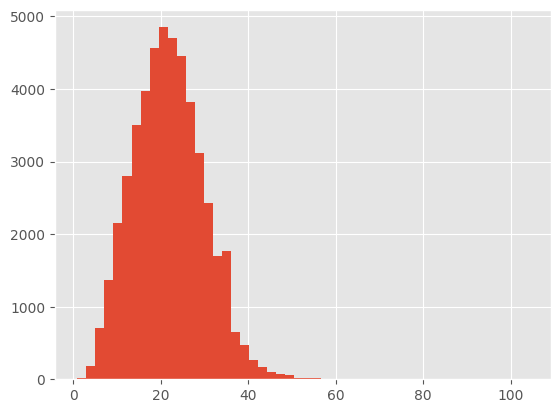

In [ ]:
#Split sentences
getter = SentenceGetter(data)
#Get the first sentence
sent = getter.get_next()
print("The first sentence is" + str(sent))

#Load all sentences
sentences = getter.sentences

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

## Convertendo frases e tags em vetores

As sentenças são convertidas em sequências de comprimento igual `max_len` (aqui 50). Um **padding** é aplicado a frases mais curtas.

Cada palavra no dicionário de entrada é atribuída a um número que será posteriormente emparelhado com um vetor (inicializado aleatoriamente).



In [ ]:
#Maximum length of the input sequences
max_len = 50

#Word and tags in the input word and tag dictionaries are numbered
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
print("The word \"Iranian\" is assigned to  " + str(word2idx["Iranian"]))
print("The tag \"B-gpe\" is assigned to " + str(tag2idx["B-gpe"]))

#Each sentence is converted into sequences of numbers, given the above dictionaries
X = [[word2idx[w[0]] for w in s] for s in sentences]

print("\nBefor PADDING")
print("Original Sentence 1:\t" + str(sentences[1]))
print("Numerical Representation 1:\t" + str(X[1]))
print("Length of Sentence 1:" + str(len(X[1])))

#APPLY PADDING
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)


print("The special word ENDPAD (used for padding) is assigned to:\t" + str(word2idx["ENDPAD"]))

print("\nAfter PADDING")
print("Numerical Representation 1:\t" + str(X[1]))
print("Length of Sentence 1:" + str(len(X[1])))


The word "Iranian" is assigned to  16881
The tag "B-gpe" is assigned to 0

Befor PADDING
Original Sentence 1:	[('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'), ('surveillance', 'NN', 'O'), ('system', 'NN', 'O'), ('begins', 'VBZ', 'O'), ('functioning', 'VBG', 'O'), ('.', '.', 'O')]
Numerical Representation 1:	[16881, 28917, 8777, 3294, 30226, 26041, 14746, 2995, 26041, 31375, 31838, 4921, 16804, 10399, 19786, 23282, 6007, 30291, 8121, 15500, 31527, 13778, 18799, 949, 3398]
Length of Sentence 1:25
The special word ENDPAD (used for padding) is assigned to:	35177

After PADDING
Numerical Represe

Os rótulos de saída também são convertidos em sequências, com comprimento máximo igual a max_len (aqui 50). Um preenchimento é aplicado a frases mais curtas, atribuindo aos elementos preenchidos o rótulo `O`.

In [ ]:
# Converting output labels into number and padding
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

print("\nAfter PADDING")
print("Output labels of 1:\t" + str(y[1]))

#Converting to categorial elements
y = [to_categorical(i, num_classes=n_tags) for i in y]

print("Categorial Output labels for the first 10 tokens:\t" + str(y[1][0:10]))



After PADDING
Output labels of 1:	[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Categorial Output labels for the first 10 tokens:	[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Dividindo a dataset

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

print("Size of the train dataset:\t" + str(len(X_tr))+ " sequences.")
print("Size of the test dataset:\t" + str(len(X_te))+ " sequences.")


Size of the train dataset:	43163 sequences.
Size of the test dataset:	4796 sequences.


## Definindo a RNN

KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758900   
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                        

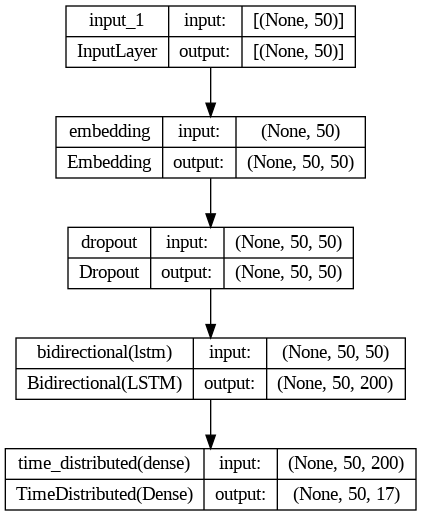

In [ ]:
input = Input(shape=(max_len,))

print(input)

# O input (agora sequências de números) são mapeadas em vetores de dimensionalidade 50
# https://keras.io/layers/embeddings/
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)

# Aplicando Dropout
# https://keras.io/layers/core/#dropout
model = Dropout(0.1)(model)

# Definindo uma LSTM
#model = LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)(model)

# Definida uma LSTM bidirecional. Observe que a saída obtida de cada palavra é
# fornecido apenas especificando return_sequences=True
# https://keras.io/layers/wrappers/
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Uma camada densa é definida para reduzir o espaço à mesma dimensionalidade da saída
# Um softmax é aplicado
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

# O modelo é compilado
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Imprimindo o modelo
model.summary()

#Visualizando em uma imagem
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')


*Vamos* treinar o modelo! *Obs: Estimativa que deve levar ~60-90min na GPU gratuita do Colab.*

In [ ]:
batch_size = 32
epochs = 20

history = model.fit(X_tr, np.array(y_tr), batch_size = batch_size, epochs = epochs, validation_split=0.1, verbose=1)

In [ ]:
model.save('modelo_treinado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Resultados na Train/Validation datasets

---



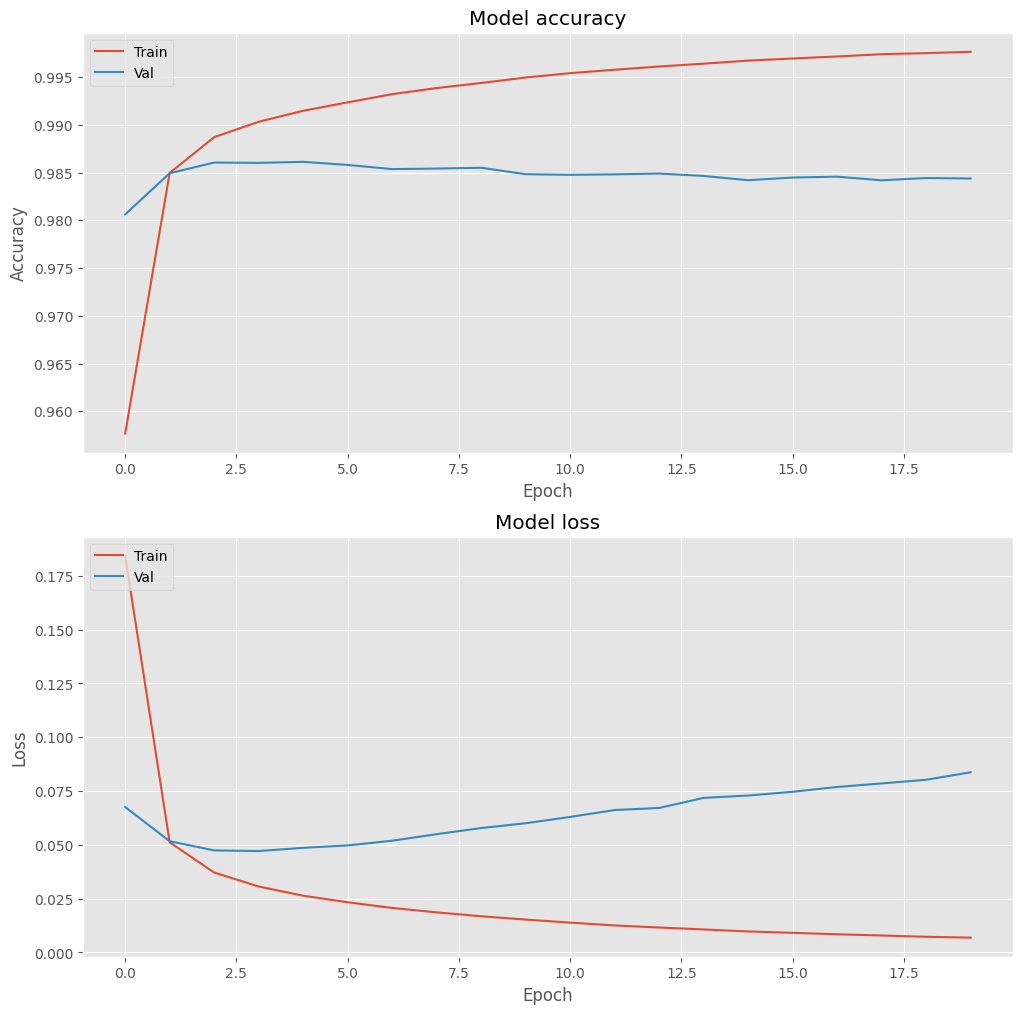

In [ ]:
# Converta o dicionário history.history em um DataFrame do pandas
hist = pd.DataFrame(history.history)

# Crie uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plotar training & validation accuracy
axs[0].plot(hist["accuracy"])
axs[0].plot(hist["val_accuracy"])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')

# Plotar training & validation loss
axs[1].plot(hist["loss"])
axs[1].plot(hist["val_loss"])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')

# Mostrar o plot
plt.show()


Vamos ver os resultados nos conjuntos de dados de teste (os últimos 10% das sentenças do conjunto de dados original)

In [ ]:
from keras.models import load_model
model2 = load_model('modelo_treinado.h5')

In [ ]:
%%time
scores = model2.evaluate(X_te, np.array(y_te), verbose=2, batch_size=100)
print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

48/48 - 5s - loss: 14.7422 - accuracy: 0.0171 - 5s/epoch - 96ms/step
accuracy: 1.71%
CPU times: user 5.06 s, sys: 104 ms, total: 5.17 s
Wall time: 5.86 s


Podemos ver agora uma frase rotulada

In [ ]:
i = 2318
p = model2.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

1/1 [==============================] - 1s 518ms/step
Word            (True ): Pred
At             : B-art
least          : B-art
three          : B-art
Palestinians   : B-art
have           : B-art
been           : B-art
wounded        : I-gpe
in             : B-art
the            : B-tim
Gaza           : B-art
Strip          : B-art
in             : B-art
what           : B-art
witnesses      : B-art
say            : B-art
was            : B-art
an             : B-art
Israeli        : B-art
attempt        : I-gpe
to             : B-art
kill           : B-art
a              : B-art
Palestinian    : B-art
militant       : B-art
.              : I-gpe
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-art
ENDPAD         : B-a

## Exercícios


1) Meça a qualidade do NER usando precision, recall e F1 score sobre entidades (em vez de accuracy sobre tokens)

In [ ]:
import numpy as np
import tensorflow as tf

y_pred = model2.predict(np.array(X_te))


150/150 [==============================] - 7s 45ms/step


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=39eb249c7ecb3ad2885ca2900dab8b12e2033996f4c5ede7fcd4afc611f55a50
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import numpy as np
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score

In [ ]:
# Converter as predições e os rótulos reais de volta para tags
def pred2label(pred, idx2tag):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

idx2tag = {i: t for t, i in tag2idx.items()}
y_te_true = pred2label(y_te, idx2tag)
y_te_pred = pred2label(y_pred, idx2tag)


In [ ]:
# Calculando precision, recall e F1 score
precision = precision_score(y_te_true, y_te_pred)
recall = recall_score(y_te_true, y_te_pred)
f1 = f1_score(y_te_true, y_te_pred)

# Exibir os resultados
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Relatório de classificação detalhado
report = classification_report(y_te_true, y_te_pred)
print(report)

Precision: 0.0008
Recall: 0.0155
F1 Score: 0.0014
              precision    recall  f1-score   support

         art       0.00      0.26      0.00        38
         eve       0.00      0.10      0.00        30
         geo       0.02      0.00      0.00      3767
         gpe       0.01      0.03      0.02      1608
         nat       0.00      0.00      0.00        19
         org       0.03      0.00      0.01      2097
         per       0.00      0.01      0.01      1750
         tim       0.02      0.04      0.03      2071

   micro avg       0.00      0.02      0.00     11380
   macro avg       0.01      0.06      0.01     11380
weighted avg       0.02      0.02      0.01     11380



2) Treine uma arquitetura de RNN 'Vanilla' e compare os resultados com a LSTM Bi-Direcional acima.

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, TimeDistributed, Dense, Dropout, Bidirectional, LSTM
from keras.optimizers import Adam

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='vanilla_rnn_model_epoch_{epoch:02d}.h5',  # Nome do arquivo para salvar o modelo
    save_freq='epoch',                                  # Salvar após cada época
    save_best_only=True,                                # Salvar apenas o melhor modelo (baseado na métrica de validação)
    monitor='val_loss',                                 # Métrica a ser monitorada
    mode='min',                                         # Modo de monitoramento (mínimo é melhor para perda)
    verbose=1                                           # Verbosidade
)

In [ ]:
# Definir o modelo RNN 'Vanilla'
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(word2idx), output_dim=50, input_length=max_len))
model_rnn.add(SimpleRNN(units=100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_rnn.add(TimeDistributed(Dense(len(tag2idx), activation="softmax")))

# Compilar o modelo
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Treinar o modelo com o callback de checkpoint
history_rnn = model_rnn.fit(
    X_tr,
    np.array(y_tr),
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
1214/1214 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9619
Epoch 1: val_loss improved from inf to 0.06425, saving model to vanilla_rnn_model_epoch_01.h5
1214/1214 [==============================] - 67s 54ms/step - loss: 0.1741 - accuracy: 0.9619 - val_loss: 0.0642 - val_accuracy: 0.9814
Epoch 2/5
   1/1214 [..............................] - ETA: 1:00 - loss: 0.0498 - accuracy: 0.9869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1214/1214 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9840
Epoch 2: val_loss improved from 0.06425 to 0.05472, saving model to vanilla_rnn_model_epoch_02.h5
1214/1214 [==============================] - 62s 51ms/step - loss: 0.0532 - accuracy: 0.9840 - val_loss: 0.0547 - val_accuracy: 0.9833
Epoch 3/5
1213/1214 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9863
Epoch 3: val_loss improved from 0.05472 to 0.05374, saving model to vanilla_rnn_model_epoch_03.h5
1214/1214 [==============================] - 63s 52ms/step - loss: 0.0428 - accuracy: 0.9863 - val_loss: 0.0537 - val_accuracy: 0.9834
Epoch 4/5
1214/1214 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9875
Epoch 4: val_loss did not improve from 0.05374
1214/1214 [==============================] - 62s 51ms/step - loss: 0.0379 - accuracy: 0.9875 - val_loss: 0.0544 - val_accuracy: 0.9834
Epoch 5/5
1214/1214 [==============================] - ETA: 0s - loss: 

In [ ]:
# Função para avaliar o modelo
def evaluate_model(y_te_true, y_te_pred):
    precision = precision_score(y_te_true, y_te_pred)
    recall = recall_score(y_te_true, y_te_pred)
    f1 = f1_score(y_te_true, y_te_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    report = classification_report(y_te_true, y_te_pred)
    print(report)

In [ ]:
# Fazer predições no conjunto de teste
y_pred_rnn = model_rnn.predict(np.array(X_te))

# Converter as predições e os rótulos reais de volta para tags
y_te_true_rnn = pred2label(y_te, idx2tag)
y_te_pred_rnn = pred2label(y_pred_rnn, idx2tag)

# Avaliar o modelo RNN 'Vanilla'
print("Evaluation for Vanilla RNN:")
evaluate_model(y_te_true_rnn, y_te_pred_rnn)

150/150 [==============================] - 1s 7ms/step
Evaluation for Vanilla RNN:
Precision: 0.7482
Recall: 0.7815
F1 Score: 0.7645
              precision    recall  f1-score   support

         art       0.24      0.18      0.21        38
         eve       0.53      0.30      0.38        30
         geo       0.79      0.85      0.82      3767
         gpe       0.95      0.93      0.94      1608
         nat       0.50      0.42      0.46        19
         org       0.52      0.60      0.56      2097
         per       0.69      0.71      0.70      1750
         tim       0.83      0.80      0.82      2071

   micro avg       0.75      0.78      0.76     11380
   macro avg       0.63      0.60      0.61     11380
weighted avg       0.75      0.78      0.77     11380



In [ ]:
# Avaliar o modelo LSTM Bi-Direcional
print("Evaluation for Bi-Directional LSTM:")
evaluate_model(y_te_true, y_te_pred)

Evaluation for Bi-Directional LSTM:
Precision: 0.0008
Recall: 0.0155
F1 Score: 0.0014
              precision    recall  f1-score   support

         art       0.00      0.26      0.00        38
         eve       0.00      0.10      0.00        30
         geo       0.02      0.00      0.00      3767
         gpe       0.01      0.03      0.02      1608
         nat       0.00      0.00      0.00        19
         org       0.03      0.00      0.01      2097
         per       0.00      0.01      0.01      1750
         tim       0.02      0.04      0.03      2071

   micro avg       0.00      0.02      0.00     11380
   macro avg       0.01      0.06      0.01     11380
weighted avg       0.02      0.02      0.01     11380

